In [1]:
import pandas as pd
from scipy.stats import qmc
import matplotlib.pyplot as plt
import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp

from pathlib import Path

In [2]:
directory_path = Path.cwd()

In [51]:
dataset_file_name = 'rubber_cb_vf_dataset_AB03_100.csv'

In [3]:
exps_file = 'doe_rubber_cb_all_vf.csv'

df = pd.read_csv(directory_path / exps_file).drop(columns=['Unnamed: 0'])
df[['F11']] = df[['dU11']] + 1.0
df[['F12']] = df[['dU12']]
df[['F21']] = df[['dU21']]
df[['F22']] = df[['dU22']] + 1.0
df.drop(columns=['dU11', 'dU12', 'dU21', 'dU22'], inplace=True)

exps = df
vfrac_dict = {0.1: 0.0980,
              0.2: 0.1944,
              0.3: 0.2916,
              0.4: 0.3932,
              0.5: 0.4904,}
# create a volume fraction column replace the values with the dictionary
# rename the column to vol_frac

exps['vol_frac'] = exps['vol_req'].replace(vfrac_dict)
exps.drop(columns=['vol_req'], inplace=True)

In [4]:
exps

,seed,F11,F12,F21,F22,vol_frac
0,10.0,1.7370,0.0033,0.0033,1.5525,0.0980
1,10.0,1.2360,-0.0140,-0.0140,1.1777,0.0980
2,10.0,0.9441,-0.2431,-0.2431,1.3054,0.0980
3,10.0,1.0169,0.1928,0.1928,1.1066,0.0980
4,10.0,1.3087,0.0086,0.0086,1.3954,0.0980
...,...,...,...,...,...,...
5115,50.0,1.5361,-0.2190,-0.2190,0.9583,0.4904
5116,50.0,0.8472,-0.0397,-0.0397,0.8367,0.4904
5117,50.0,1.6784,0.0178,0.0178,1.6670,0.4904
5118,50.0,1.1028,0.0300,0.0300,1.4193,0.4904


In [5]:
def_grad_doe = exps[['F11', 'F12', 'F21', 'F22']].values.reshape(-1, 2, 2)

vol_frac_doe = exps['vol_frac'].values

samples_path = Path('outputs/562684.hpc06.hpc/Data/')

n_experiments = len(exps)

In [6]:
def pk2_stress(deformation_gradient, pk1_stress):
    return jnp.matmul(jnp.linalg.inv(deformation_gradient), pk1_stress)

In [7]:
def gl_strain(deformation_gradient):
    C = deformation_gradient.T @ deformation_gradient
    E = 0.5 * (C - jnp.eye(2))
    return E

In [8]:
raw_data = pd.DataFrame(columns=['F11', 'F12', 'F21', 'F22', 'P11', 'P12', 'P21', 'P22', 'vol_frac'])
idx = 0
for i in range(n_experiments):
    experiment_folder = samples_path / f'point_{i}'
    result_file = experiment_folder / Path('results.p')

    try:
        result = pd.read_pickle(result_file)

        # get the deformation gradient and pk1 stress
        F = result['deformation_gradient'][-1]
        P = result['pk1_stress'][-1]
        raw_data.loc[i] = [F[0,0], F[0,1], F[1,0], F[1,1], P[0,0], P[0,1], P[1,0], P[1,1], vol_frac_doe[i]]
        idx += 1

    except FileNotFoundError:
        print(idx, "No data")
        raw_data.loc[idx] = [0.0]*8 + [vol_frac_doe[i]]
        idx += 1

In [9]:
raw_data

,F11,F12,F21,F22,P11,P12,P21,P22,vol_frac
0,1.73700,0.003300,0.003300,1.552500,5.947655,-0.011495,-0.011508,6.584209,0.0980
1,1.23600,-0.014000,-0.014000,1.177700,1.525495,0.010068,0.010060,1.568042,0.0980
2,0.94410,-0.243100,-0.243100,1.305400,0.542226,-0.036024,-0.035878,0.594979,0.0980
3,1.01690,0.192800,0.192800,1.106600,0.266684,0.081247,0.081276,0.304655,0.0980
4,1.30870,0.008600,0.008600,1.395400,2.926663,-0.014177,-0.014170,2.784876,0.0980
...,...,...,...,...,...,...,...,...,...
5115,1.35673,-0.145726,-0.145726,0.972252,1.645041,-0.003493,0.001825,1.600347,0.4904
5116,0.84720,-0.039700,-0.039700,0.836700,-2.788871,-0.292932,-0.288537,-2.958972,0.4904
5117,1.67840,0.017800,0.017800,1.667000,10.726282,-0.104258,-0.104130,10.805032,0.4904
5118,1.10280,0.030000,0.030000,1.419300,3.317226,-0.045504,-0.043471,2.933317,0.4904


In [10]:
def_grad = raw_data[['F11', 'F12', 'F21', 'F22']].values.reshape(-1, 2, 2)
pk1_simulated = raw_data[['P11', 'P12', 'P21', 'P22']].values.reshape(-1, 2, 2)

In [11]:
pk2_simulated = jax.vmap(pk2_stress)(def_grad, pk1_simulated)
gl_strain_simulated = jax.vmap(gl_strain)(def_grad)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [15]:
dataset = pd.DataFrame()
dataset['vol_frac'] = raw_data['vol_frac']
dataset['E11'] = gl_strain_simulated[:,0,0]
dataset['E22'] = gl_strain_simulated[:,1,1]
dataset['E12'] = gl_strain_simulated[:,0,1]
dataset['S11'] = pk2_simulated[:,0,0]
dataset['S22'] = pk2_simulated[:,1,1]
dataset['S12'] = 0.5*(pk2_simulated[:,0,1]+pk2_simulated[:,1,0])

In [16]:
dataset

,vol_frac,E11,E22,E12,S11,S22,S12
0,0.0980,1.008590,0.705134,0.005428,3.424124,4.241068,-0.014683
1,0.0980,0.263946,0.193587,-0.016896,1.234482,1.331721,0.023223
2,0.0980,-0.024789,0.381583,-0.273427,0.595825,0.471275,0.083334
3,0.0980,0.035629,0.130868,0.204705,0.256810,0.270316,0.028675
4,0.0980,0.356385,0.473608,0.011628,2.236470,1.995902,-0.023943
...,...,...,...,...,...,...,...
5115,0.4904,0.430976,-0.016745,-0.169697,1.232549,1.672562,0.181847
5116,0.4904,-0.140338,-0.149179,-0.033425,-3.315399,-3.560802,-0.507393
5117,0.4904,0.908672,0.889603,0.029774,6.392165,6.483120,-0.130797
5118,0.4904,0.108534,0.507656,0.037831,3.010568,2.068797,-0.095902


In [35]:
def check_isclose(matrix1, matrix2, atol=1e-2):
    return jnp.allclose(matrix1, matrix2, atol)

def check_symmetry(matrix):
    # we check the symmetry of the matrix by checking if the matrix is close to its transpose
    # we use a relative tolerance of 10% and an absolute tolerance of 0.01
    return jnp.allclose(matrix, matrix.T, rtol=0.1, atol=0.01)

In [36]:
incomplete_sim = jnp.array(jnp.where(jax.vmap(check_isclose)(def_grad, def_grad_doe) == False)).reshape(-1)

unsymmetric_pk2 = jnp.array(jnp.where(jax.vmap(check_symmetry)(pk2_simulated) == False)).reshape(-1)

In [47]:
exclude_list = jnp.unique(jnp.concatenate((incomplete_sim, unsymmetric_pk2)))
len(exclude_list)

333

In [48]:

dataset = dataset.drop(exclude_list).reset_index(drop=True).round(4)
dataset

,vol_frac,E11,E22,E12,S11,S22,S12
0,0.0980,1.0086,0.7051,0.0054,3.4241,4.2411,-0.0147
1,0.0980,0.2639,0.1936,-0.0169,1.2345,1.3317,0.0232
2,0.0980,-0.0248,0.3816,-0.2734,0.5958,0.4713,0.0833
3,0.0980,0.0356,0.1309,0.2047,0.2568,0.2703,0.0287
4,0.0980,0.3564,0.4736,0.0116,2.2365,1.9959,-0.0239
...,...,...,...,...,...,...,...
4782,0.4904,0.7649,-0.0810,0.2209,1.2848,2.4448,-0.3270
4783,0.4904,-0.1403,-0.1492,-0.0334,-3.3154,-3.5608,-0.5074
4784,0.4904,0.9087,0.8896,0.0298,6.3922,6.4831,-0.1308
4785,0.4904,0.1085,0.5077,0.0378,3.0106,2.0688,-0.0959


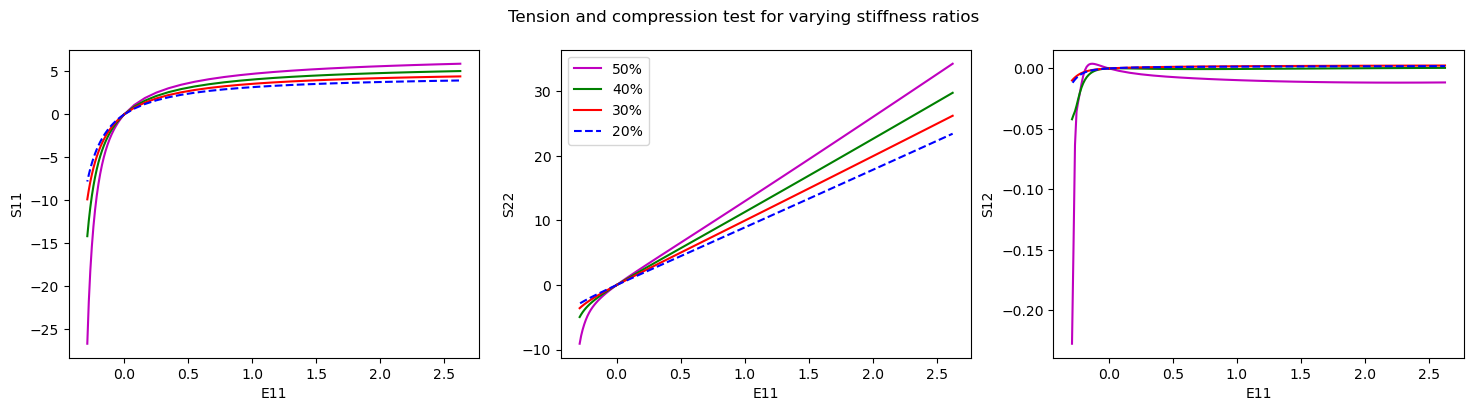

In [13]:
# plot the stress-strain curve for each experiment. Plot all samples in the same plot

# Tension test and compression test
line_styles = ['-', '-', '-', '--']
colors = ['m', 'g', 'r', 'b']

fig, ax = plt.subplots(1, 3, squeeze=False, figsize=(18, 4))
experiments = ['tension', 'compression']
for experiment in experiments:
    for sample, data, line_style, color in zip(full_experiment_dict[experiment].keys(), full_experiment_dict[experiment].values(), line_styles, colors):
        if experiment == 'tension':
            ax[0][0].plot(data['E11'], data['S11'], label=sample, linestyle=line_style, color=color)
            ax[0][1].plot(data['E11'], data['S22'], label=sample, linestyle=line_style, color=color)
            ax[0][2].plot(data['E11'], 0.5*(data['S12'] + data['S21']), label=sample, linestyle=line_style, color=color)
            # pass

        else:
            ax[0][0].plot(data['E11'], data['S11'], linestyle=line_style, color=color)
            ax[0][1].plot(data['E11'], data['S22'], linestyle=line_style, color=color)
            ax[0][2].plot(data['E11'], 0.5*(data['S12'] + data['S21']), linestyle=line_style, color=color)
            # pass
# ax.set_title('Tension test')
ax[0][0].set_xlabel('E11')
ax[0][0].set_ylabel('S11')
ax[0][1].set_xlabel('E11')
ax[0][1].set_ylabel('S22')
ax[0][2].set_xlabel('E11')
ax[0][2].set_ylabel('S12')
fig.suptitle('Tension and compression test for varying stiffness ratios')
ax[0][1].legend()
plt.show()

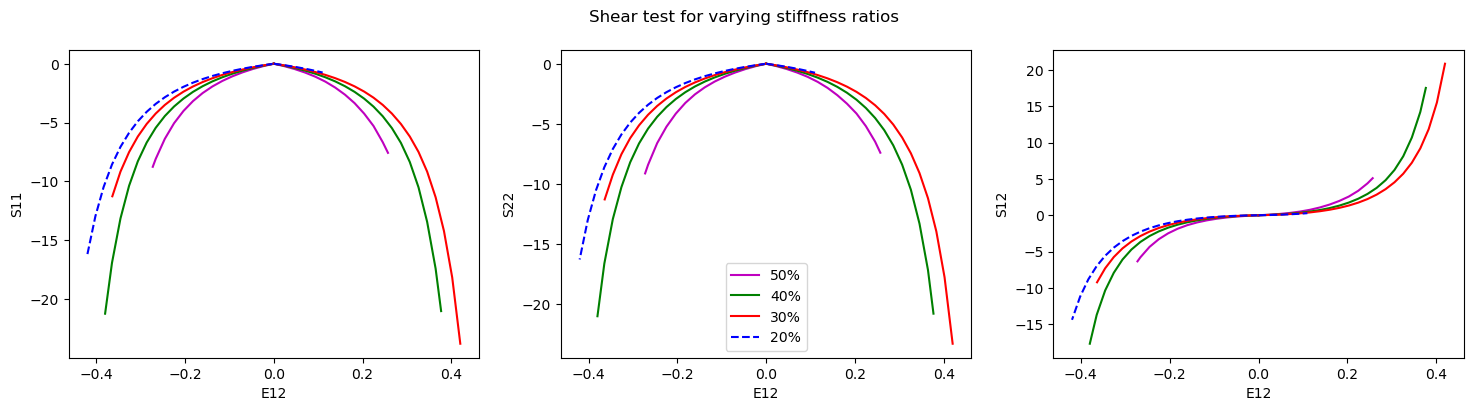

In [14]:
# plot the stress-strain curve for each experiment. Plot all samples in the same plot

# Shear test
line_styles = ['-', '-', '-', '--']
colors = ['m', 'g', 'r', 'b']

fig, ax = plt.subplots(1, 3, squeeze=False, figsize=(18, 4))
experiments = ['shear-', 'shear+']
for experiment in experiments:
    for sample, data, line_style, color in zip(full_experiment_dict[experiment].keys(), full_experiment_dict[experiment].values(), line_styles, colors):
        if experiment == 'shear-':
            ax[0][0].plot(data['E12'], data['S11'], label=sample, linestyle=line_style, color=color)
            ax[0][1].plot(data['E12'], data['S22'], label=sample, linestyle=line_style, color=color)
            ax[0][2].plot(data['E12'], 0.5*(data['S12'] + data['S21']), label=sample, linestyle=line_style, color=color)

        else:
            ax[0][0].plot(data['E12'], data['S11'], linestyle=line_style, color=color)
            ax[0][1].plot(data['E12'], data['S22'], linestyle=line_style, color=color)
            ax[0][2].plot(data['E12'], 0.5*(data['S12'] + data['S21']), linestyle=line_style, color=color)
# ax.set_title('Tension test')
ax[0][0].set_xlabel('E12')
ax[0][0].set_ylabel('S11')
ax[0][1].set_xlabel('E12')
ax[0][1].set_ylabel('S22')
ax[0][2].set_xlabel('E12')
ax[0][2].set_ylabel('S12')
fig.suptitle('Shear test for varying stiffness ratios')
ax[0][1].legend()
plt.show()

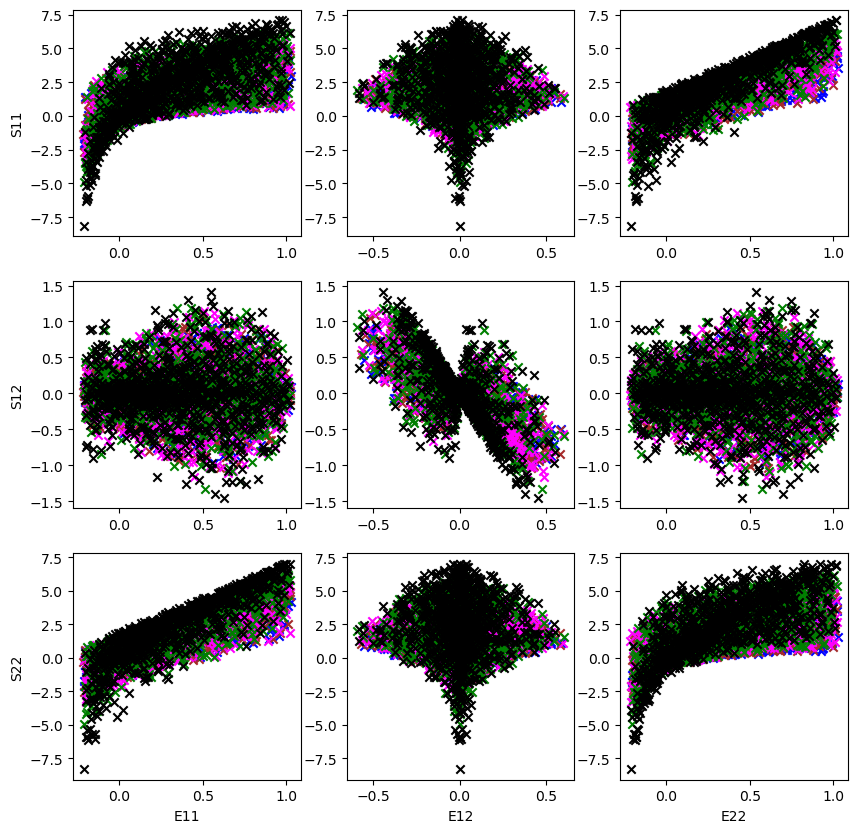

In [50]:
rows = 3
cols = 3
fig, ax = plt.subplots(nrows = rows, ncols = cols)
xlabels = ['E11', 'E12', 'E22']
ylabels = ['S11', 'S12', 'S22']
# colors = [['blue', 'brown', 'magenta'],
#           ['green', 'black', 'green'],
#           ['magenta', 'brown', 'blue']]
colors = ['blue', 'brown', 'magenta', 'green', 'black']
vfrac = dataset['vol_frac'].unique()
# vfrac = [vfrac[1]]
for i in range(len(vfrac)):
    for row in range(rows):
        ax[row][0].set_ylabel(ylabels[row])
        for col in range(cols):
            df = dataset[dataset['vol_frac'] == vfrac[i]]
            x = df[xlabels[col]]
            y = df[ylabels[row]]
            
            ax[row][col].scatter(x, y, marker = "x", color = colors[i])
            if row+1 == rows:
                ax[row][col].set_xlabel(xlabels[col])
fig.set_size_inches(10, 10)
plt.show()



In [52]:
dataset.to_csv(directory_path / Path(dataset_file_name), index=False)